#Random Forest To Predict the Winner

Given the data that we gathered from Riot's database, we wanted to figure out which features would be important to look at to predict the winning team. **Random Forest** is a useful tool to figure out how important each features were, based on how many decision trees they are found in. 

Random Forests is powerful because it is unexcelled in accuracy among current algorithms, runs efficiently on large data bases, and is able to give the relative importance of each variable that we are testing. 


In [459]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

We've created a csv file using a package called 'Cassiopeia', which is used to query and parse through data we've obtained from Riot's database. We'll read in this csv file and create a **panda dataframe**. We'll print the head of the dataframe to see what we're working with.

**LEO NOTE: I didn't use the newdf that you made Andy, just delete the part where I create a new dataframe without diffturr and diffinhib**

In [501]:
df = pd.read_csv('newdf.csv')
df.head()

,diffbaron,diffcc,diffcs,diffdmg,diffdrag,diffgold,diffinhib,diffkda,diffrange,diffspree,difftank,diffturr,fbaron,fblood,fdrag,finhib,fturret,win
0,1,819,155,17067,3,17703,2,18.144444,-1,5,0,8,True,False,True,True,False,True
1,1,-685,24,-23447,0,-11396,-2,-20.117208,1,-7,1,-4,True,False,True,False,False,False
2,-1,658,16,-5988,0,-11734,-2,-21.416667,1,-3,1,-6,False,True,True,False,True,False
3,-1,-339,-127,-9102,-2,-17661,-2,-17.531349,1,-6,0,-7,False,False,False,False,False,False
4,0,756,162,12505,0,11899,1,26.059524,0,3,3,5,False,False,False,True,True,True


In [502]:
cols = list(df.columns)

In [503]:
print cols

['diffbaron', 'diffcc', 'diffcs', 'diffdmg', 'diffdrag', 'diffgold', 'diffinhib', 'diffkda', 'diffrange', 'diffspree', 'difftank', 'diffturr', 'fbaron', 'fblood', 'fdrag', 'finhib', 'fturret', 'win']


In [504]:
#removing win conditions since they are bad variables
cols.remove('diffturr')
cols.remove('diffinhib')

In [505]:
dftouse = df[cols]
dftouse.head()

,diffbaron,diffcc,diffcs,diffdmg,diffdrag,diffgold,diffkda,diffrange,diffspree,difftank,fbaron,fblood,fdrag,finhib,fturret,win
0,1,819,155,17067,3,17703,18.144444,-1,5,0,True,False,True,True,False,True
1,1,-685,24,-23447,0,-11396,-20.117208,1,-7,1,True,False,True,False,False,False
2,-1,658,16,-5988,0,-11734,-21.416667,1,-3,1,False,True,True,False,True,False
3,-1,-339,-127,-9102,-2,-17661,-17.531349,1,-6,0,False,False,False,False,False,False
4,0,756,162,12505,0,11899,26.059524,0,3,3,False,False,False,True,True,True


<span style = "font-size: 1.5em;">Getting on with the classifier</span>

Now, let's get on with our random forest classifier.

First we want to create mask values so we can split the dataframe into training and testing sets. To do that we import `train_test_split`, and create mask values.

In [506]:
###Random forest classifier
from sklearn.cross_validation import train_test_split
itrain, itest = train_test_split(xrange(dftouse.shape[0]), train_size=0.75)

In [507]:
mask=np.ones(dftouse.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

In [508]:
#seeing if it worked out correctly
mask.shape, mask.sum()

((20223,), 15167)

We define lcols to be the columns of the variables that we want to know about. We do this by creating a list of the our column names and then removing 'win' as that is the response variable.

In [509]:
#Now we will be using a Random Forest classifier to figure out which features are more 
#important in determining the probability of a team winning. First, we split the data set.

#columns with values to fit as the X values
lcols = list(dftouse.columns.values)
#removing the win (y) response variables from the list
lcols.remove('win')
print(lcols)

['diffbaron', 'diffcc', 'diffcs', 'diffdmg', 'diffdrag', 'diffgold', 'diffkda', 'diffrange', 'diffspree', 'difftank', 'fbaron', 'fblood', 'fdrag', 'finhib', 'fturret']


Don't forget to `import` the `RandomForestClassifier`!

In [510]:
from sklearn.ensemble import RandomForestClassifier

First, we'll create a `RandomForestClassifier` with the default parameters that we can use to optimize later.

In [511]:
clfForest = RandomForestClassifier()

We define two functions: `cv_optimize` and `do_classify`, derived from pset3.

`cv_optimize` takes in:
* clf as the original classifer (which in our case is clfForest) 
* the parameters to search over (we will be optimizing the n_estimator parameter)
* The X training matrix
* The y training vector

It returns the *best* parameter, according to the score.

`do_classify` uses `cv_optimize` and outputs the **X training matrix, y training vector, X test matrix, y test vector, the new optimized and fitted classifier, and the accuracy of the new model on the training and test sets**.

`do_classify` takes in:
* indf as the input dataframe (dftouse)
* featurenames as the variables we want to test (lcols)
* targetname as the variable we want predict (win)
* mask, the boolean vector indicator test set
* n_jobs, used for parallelization
* score_func, algorithm used to determine score

In [512]:
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import confusion_matrix

def cv_optimize(clf, parameters, X, y, n_jobs=1, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
    gs.fit(X, y)
    print "BEST", gs.best_params_, gs.best_score_, gs.grid_scores_
    best = gs.best_estimator_
    return best

def do_classify(clf, parameters, indf, featurenames, targetname, target1val, mask=None, reuse_split =None: score_func=None, n_folds=5, n_jobs=1):
    subdf=indf[featurenames]
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    if mask !=None:
        print "using mask"
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_jobs=n_jobs, n_folds=n_folds, score_func=score_func)
    if reuse_split !=None:
        print "using reuse split"
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print "############# based on standard predict ################"
    print "Accuracy on training data: %0.2f" % (training_accuracy)
    print "Accuracy on test data:     %0.2f" % (test_accuracy)
    print confusion_matrix(ytest, clf.predict(Xtest))
    print "########################################################"
    return clf, Xtrain, ytrain, Xtest, ytest

We want to optimize `n_estimators`, which is the number of trees in the forest. We wanted a large number of trees in the forest so we can better identify which features are more important; so we'll test to see up to 99 trees. Then, we'll run `do_classify`.

In [515]:
parameters = {"n_estimators": range(1, 100)}
clfForest, Xtrain, ytrain, Xtest, ytest = do_classify(clfForest, parameters, 
                                                       dftouse, lcols, 'win', 1, mask=mask, 
                                                       n_jobs = 4, score_func='f1')

using mask


/Users/leosjk/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:46: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


BEST {'n_estimators': 74} 0.977412389955 [mean: 0.95984, std: 0.00385, params: {'n_estimators': 1}, mean: 0.96176, std: 0.00370, params: {'n_estimators': 2}, mean: 0.97171, std: 0.00416, params: {'n_estimators': 3}, mean: 0.96886, std: 0.00338, params: {'n_estimators': 4}, mean: 0.97422, std: 0.00269, params: {'n_estimators': 5}, mean: 0.97431, std: 0.00131, params: {'n_estimators': 6}, mean: 0.97356, std: 0.00299, params: {'n_estimators': 7}, mean: 0.97389, std: 0.00324, params: {'n_estimators': 8}, mean: 0.97441, std: 0.00348, params: {'n_estimators': 9}, mean: 0.97690, std: 0.00327, params: {'n_estimators': 10}, mean: 0.97562, std: 0.00344, params: {'n_estimators': 11}, mean: 0.97559, std: 0.00304, params: {'n_estimators': 12}, mean: 0.97509, std: 0.00357, params: {'n_estimators': 13}, mean: 0.97546, std: 0.00376, params: {'n_estimators': 14}, mean: 0.97616, std: 0.00296, params: {'n_estimators': 15}, mean: 0.97667, std: 0.00357, params: {'n_estimators': 16}, mean: 0.97617, std: 0.0

The best parameter value is 74, with a score of 0.977. Let's print the clfForest to see its features.

In [516]:
clfForest

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=74, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Let's store the training and test sets in `reuse_split` so we can use them later with consistent sets.

In [526]:
reuse_split=dict(Xtrain=Xtrain, Xtest=Xtest, ytrain=ytrain, ytest=ytest)

<span style = "font-size: 1.34em"> Visualizing the results <span>

We'll first visualize the relative importance of each feature. The importances sum up to 1, which gives us an interesting insight into how important each feature was in predicting the winner. `feature_importances` returns the importances.

In [517]:
#We can plot the importances
importances = clfForest.feature_importances_

We'll sort the importances and column names so they match up.

In [518]:
imp_sort, lcols_sort = zip(*sorted(zip(importances, lcols)))

We'll use a horizontal bar chart to compare the importances. 

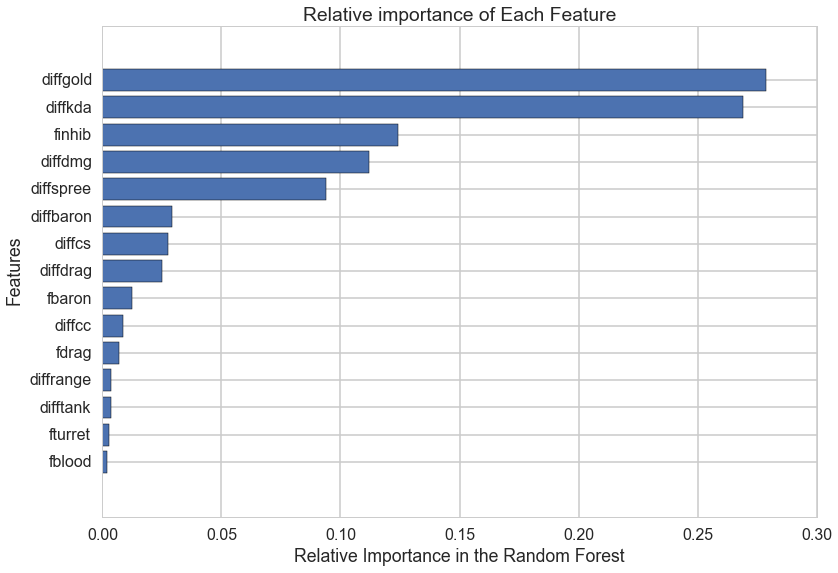

In [519]:
#plot importances
plt.barh(range(len(lcols_sort)),imp_sort,align='center')
plt.yticks(range(len(lcols_sort)),lcols_sort)
plt.xlabel('Relative Importance in the Random Forest')
plt.ylabel('Features')
plt.title('Relative importance of Each Feature')
plt.show()

We see that the results show us that the five most important variables in predicting the winner of the game are difference in gold earned, difference in kill-death-assist ratio, who got the first inhib, difference in damage dealt to champions, and difference in the number of killing sprees. Comparatively, we see that difference in the number of type of champions, such as "tank" and "ranged", were very weak variables, as well as who got first blood and who got first turret. 

Standardizing the dataframe stuff

In [468]:
#Standardizeable variables
stdz = list(dftouse.columns)
stdz.remove('win')
stdz.remove('fblood') 
stdz.remove('finhib')
stdz.remove('fdrag')
stdz.remove('fbaron')
stdz.remove('fturret')
print(stdz)

['diffbaron', 'diffcc', 'diffcs', 'diffdmg', 'diffdrag', 'diffgold', 'diffkda', 'diffrange', 'diffspree', 'difftank']


In [469]:
#adding mask column
dftouse['Mask'] = mask
#trainset to fit and standardize
trainset = dftouse.query('Mask == True')
testset = dftouse.query('Mask == False')
#test set train set
trainset = trainset[stdz]
testset = testset[stdz]

/Users/leosjk/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


In [470]:
#standardizing our data
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
preprocessing.StandardScaler().fit(trainset)
fitdf = preprocessing.StandardScaler().fit_transform(dftouse[stdz])
newdf = pd.DataFrame(fitdf)
newdf.columns = trainset.columns

In [471]:
#replace values
dftouse[stdz] = newdf
dftouse.head()

,diffbaron,diffcc,diffcs,diffdmg,diffdrag,diffgold,diffkda,diffrange,diffspree,difftank,fbaron,fblood,fdrag,finhib,fturret,win,Mask
0,1.012372,0.427762,1.615697,0.818152,1.487001,1.482770,0.744954,-0.848866,1.306314,-0.005191,True,False,True,True,False,True,True
1,1.012372,-0.346850,0.360326,-1.028140,0.112277,-0.836434,-0.728606,0.857049,-1.736486,0.957995,True,False,True,False,False,False,True
2,-0.875690,0.344841,0.283662,-0.232503,0.112277,-0.863373,-0.778652,0.857049,-0.722219,0.957995,False,True,True,False,True,False,True
3,-0.875690,-0.168648,-1.086705,-0.374414,-0.804205,-1.335757,-0.629018,0.857049,-1.482920,-0.005191,False,False,False,False,False,False,True
4,0.068341,0.395315,1.682778,0.610254,0.112277,1.020188,1.049785,0.004091,0.799181,2.884368,False,False,False,True,True,True,True


In [473]:
Xmatrix = dftouse[lcols].values
yvals = dftouse['win'].values

In [474]:
##split to train and test
X_train = Xmatrix[mask]
X_test = Xmatrix[~mask]
y_train = yvals[mask]
y_test = yvals[~mask]

In [529]:
print len(mask[itest])
print len(mask[itrain])
if ytest.all() == y_test.all():
    print("Yay")

5056
15167
Yay


In [477]:
#We can graph importances.
#First we fit
clfForest = clfForest.fit(X_train, y_train)